### prueba de función.

def transform_data(df):
    #limpieza DF
    df.columns=df.columns.str.upper().str.replace(' ','_')
    media=np.median(df['MONTHS_SINCE_LAST_CLAIM'])
    df['MONTHS_SINCE_LAST_CLAIM']=df['MONTHS_SINCE_LAST_CLAIM'].fillna(media)
    media2=np.median(df['NUMBER_OF_OPEN_COMPLAINTS'])
    df['NUMBER_OF_OPEN_COMPLAINTS']=df['NUMBER_OF_OPEN_COMPLAINTS'].fillna(media2)
    columns_to_fill= ['STATE', 'RESPONSE', 'VEHICLE_CLASS', 'VEHICLE_SIZE', 'VEHICLE_TYPE']
    df[columns_to_fill] = df[columns_to_fill].fillna('unknown')
    df['EFFECTIVE_TO_DATE']=pd.to_datetime(df['EFFECTIVE_TO_DATE'])
    df['months']=df['EFFECTIVE_TO_DATE'].dt.month
    df2=df[df['months'].isin([1,2,3])]
    df3=df.drop(['UNNAMED:_0','Unnamed: 0'], axis=1)
    #separo numericas.
    numerical = df3.select_dtypes(include=np.number)
    categoricals = df3.select_dtypes(include=object)
    media1=np.mean(numerical['MONTHS_SINCE_LAST_CLAIM'])
    media2=np.mean(numerical['NUMBER_OF_OPEN_COMPLAINTS'])
    numerical['MONTHS_SINCE_LAST_CLAIM']=numerical['MONTHS_SINCE_LAST_CLAIM'].fillna(media1)
    numerical['NUMBER_OF_OPEN_COMPLAINTS']=numerical['NUMBER_OF_OPEN_COMPLAINTS'].fillna(media2)
    #normalizo
    Y=numerical['TOTAL_CLAIM_AMOUNT']
    X=numerical.drop('TOTAL_CLAIM_AMOUNT', axis=1)
    transformer=StandardScaler().fit(numerical)
    x_normalized=transformer.transform(numerical)
    pd.DataFrame(x_normalized)
    new_columns=numerical.columns.tolist()
    x_normalized.columns= new_columns
    #separo categoricas.
    dfcategorica=df.copy()
    dfcategorica=df.drop(['EFFECTIVE_TO_DATE', 'CUSTOMER'],axis=1)
    X_cat = dfcategorica.select_dtypes(include=object)
    #trabajo variables categoricas
    encoder = OneHotEncoder(handle_unknown='error', drop='first')
    encoder.fit(X_cat)
    encoded = encoder.transform(X_cat).toarray()
    feature_names = encoder.get_feature_names_out(X_cat.columns)
    X_cat_encoded = pd.DataFrame(encoded, columns=feature_names)
    datatest = X_cat.drop(X_cat.columns, axis=1)
    datatest = pd.concat([datatest, X_cat_encoded], axis=1)
    
    return df_q1

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import norm
from scipy import stats 
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [8]:
df=pd.read_csv("marketing_customer_analysis.csv")
#estandarizo los nombres de columnas. 
df.columns=df.columns.str.upper().str.replace(' ','_')
df1=df.copy()

In [9]:
#1º hago la distinción de variables numericas y categoricas. 
numerical = df1.select_dtypes(include=np.number)
categoricals = df1.select_dtypes(include=object)

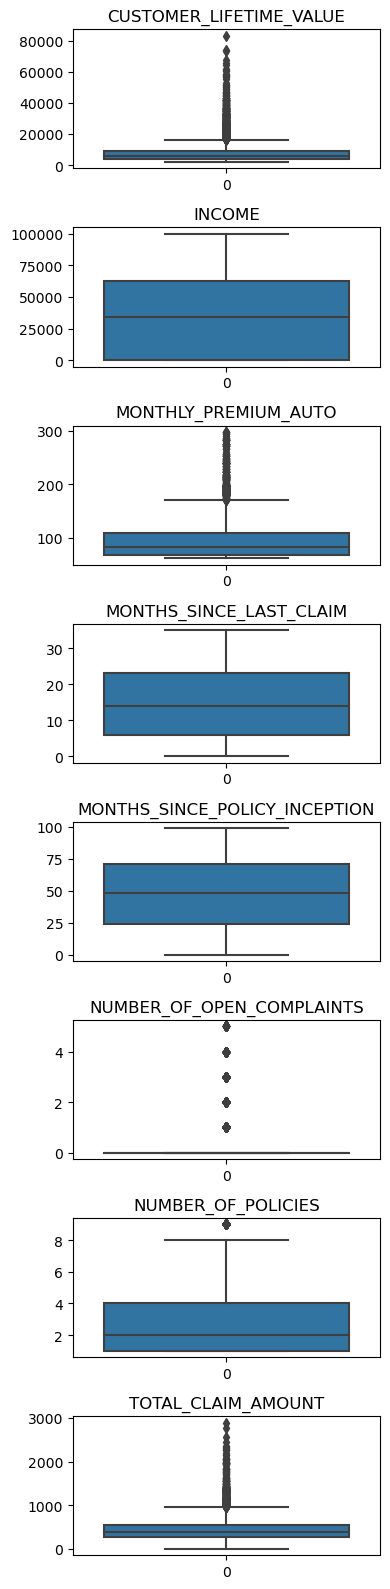

In [35]:
#Grafico de control.
fig, axes = plt.subplots(len(numerical.columns), 1, figsize=(4, 2* len(numerical.columns)))

for i, column in enumerate(numerical.columns):
    sns.boxplot(numerical[column], ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()      

In [76]:
# 2º Normalizo la variables numericas. 
#Y=numerical['TOTAL_CLAIM_AMOUNT']
#X=numerical.drop('TOTAL_CLAIM_AMOUNT', axis=1)
transformer=StandardScaler().fit(numerical)
x_normalized=transformer.transform(numerical)
df_norm=pd.DataFrame(x_normalized)
df_norm


,0,1,2,3,4,5,6,7
0,-0.762878,0.612827,-0.703925,1.678099,-1.543287,-0.422250,-0.822648,-0.169640
1,-0.149245,-1.239617,0.022691,-0.208186,-0.217334,-0.422250,2.106160,2.400737
2,0.710636,0.365710,0.429596,0.288205,-0.360680,-0.422250,-0.404247,0.455734
3,-0.052263,-1.239617,0.371467,0.288205,0.606907,-0.422250,1.687759,0.329769
4,-0.755575,0.203390,-0.587666,-0.307465,-0.145661,-0.422250,-0.822648,-1.018843
...,...,...,...,...,...,...,...,...
9129,2.241590,1.128558,-0.587666,0.288205,1.466984,-0.422250,-0.404247,-0.811934
9130,-0.714411,-0.528450,-0.413278,-0.108908,-0.719046,-0.422250,-0.822648,-0.188956
9131,0.023135,-1.239617,-0.238891,-0.605299,-0.396517,2.873245,-0.404247,1.227937
9132,-0.069935,-0.517356,0.080820,1.876656,-1.614960,-0.422250,0.014154,0.885113


In [77]:
#Cambio nombres del Df normalizado y lo reemplazo por los nombres d elas columnas del DF numerico.
col_num=numerical.columns
df_norm.columns=col_num
df_norm

,CUSTOMER_LIFETIME_VALUE,INCOME,MONTHLY_PREMIUM_AUTO,MONTHS_SINCE_LAST_CLAIM,MONTHS_SINCE_POLICY_INCEPTION,NUMBER_OF_OPEN_COMPLAINTS,NUMBER_OF_POLICIES,TOTAL_CLAIM_AMOUNT
0,-0.762878,0.612827,-0.703925,1.678099,-1.543287,-0.422250,-0.822648,-0.169640
1,-0.149245,-1.239617,0.022691,-0.208186,-0.217334,-0.422250,2.106160,2.400737
2,0.710636,0.365710,0.429596,0.288205,-0.360680,-0.422250,-0.404247,0.455734
3,-0.052263,-1.239617,0.371467,0.288205,0.606907,-0.422250,1.687759,0.329769
4,-0.755575,0.203390,-0.587666,-0.307465,-0.145661,-0.422250,-0.822648,-1.018843
...,...,...,...,...,...,...,...,...
9129,2.241590,1.128558,-0.587666,0.288205,1.466984,-0.422250,-0.404247,-0.811934
9130,-0.714411,-0.528450,-0.413278,-0.108908,-0.719046,-0.422250,-0.822648,-0.188956
9131,0.023135,-1.239617,-0.238891,-0.605299,-0.396517,2.873245,-0.404247,1.227937
9132,-0.069935,-0.517356,0.080820,1.876656,-1.614960,-0.422250,0.014154,0.885113


In [36]:
#Comienzo a rabajar con las variables CATEGORICAS.
categoricals

,CUSTOMER,STATE,RESPONSE,COVERAGE,EDUCATION,EFFECTIVE_TO_DATE,EMPLOYMENTSTATUS,GENDER,LOCATION_CODE,MARITAL_STATUS,POLICY_TYPE,POLICY,RENEW_OFFER_TYPE,SALES_CHANNEL,VEHICLE_CLASS,VEHICLE_SIZE
0,BU79786,Washington,No,Basic,Bachelor,2/24/11,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,QZ44356,Arizona,No,Extended,Bachelor,1/31/11,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,AI49188,Nevada,No,Premium,Bachelor,2/19/11,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize
3,WW63253,California,No,Basic,Bachelor,1/20/11,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize
4,HB64268,Washington,No,Basic,Bachelor,2/3/11,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,California,No,Basic,Bachelor,2/10/11,Employed,M,Urban,Married,Personal Auto,Personal L1,Offer2,Web,Four-Door Car,Medsize
9130,PK87824,California,Yes,Extended,College,2/12/11,Employed,F,Suburban,Divorced,Corporate Auto,Corporate L3,Offer1,Branch,Four-Door Car,Medsize
9131,TD14365,California,No,Extended,Bachelor,2/6/11,Unemployed,M,Suburban,Single,Corporate Auto,Corporate L2,Offer1,Branch,Four-Door Car,Medsize
9132,UP19263,California,No,Extended,College,2/3/11,Employed,M,Suburban,Married,Personal Auto,Personal L2,Offer3,Branch,Four-Door Car,Large


In [38]:
#Elimino columnas que no tienen implicación en el analisis. Defino un nuevo DF sin esas columnas. 
df_categ=categoricals.drop(['EFFECTIVE_TO_DATE', 'CUSTOMER'],axis=1)
df_categ

,STATE,RESPONSE,COVERAGE,EDUCATION,EMPLOYMENTSTATUS,GENDER,LOCATION_CODE,MARITAL_STATUS,POLICY_TYPE,POLICY,RENEW_OFFER_TYPE,SALES_CHANNEL,VEHICLE_CLASS,VEHICLE_SIZE
0,Washington,No,Basic,Bachelor,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,Arizona,No,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,Nevada,No,Premium,Bachelor,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize
3,California,No,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize
4,Washington,No,Basic,Bachelor,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,California,No,Basic,Bachelor,Employed,M,Urban,Married,Personal Auto,Personal L1,Offer2,Web,Four-Door Car,Medsize
9130,California,Yes,Extended,College,Employed,F,Suburban,Divorced,Corporate Auto,Corporate L3,Offer1,Branch,Four-Door Car,Medsize
9131,California,No,Extended,Bachelor,Unemployed,M,Suburban,Single,Corporate Auto,Corporate L2,Offer1,Branch,Four-Door Car,Medsize
9132,California,No,Extended,College,Employed,M,Suburban,Married,Personal Auto,Personal L2,Offer3,Branch,Four-Door Car,Large


In [39]:
#aplico el hot encoder a las variables numericas. 
encoder = OneHotEncoder(handle_unknown='error', drop='first')
encoder.fit(df_categ)
encoded = encoder.transform(df_categ).toarray()
feature_names = encoder.get_feature_names_out(df_categ.columns)
X_cat_encoded = pd.DataFrame(encoded, columns=feature_names)
df_encod = df_categ.drop(df_categ.columns, axis=1)
df_encod = pd.concat([df_encod, X_cat_encoded], axis=1)
df_encod

,STATE_California,STATE_Nevada,STATE_Oregon,STATE_Washington,RESPONSE_Yes,COVERAGE_Extended,COVERAGE_Premium,EDUCATION_College,EDUCATION_Doctor,EDUCATION_High School or Below,...,SALES_CHANNEL_Branch,SALES_CHANNEL_Call Center,SALES_CHANNEL_Web,VEHICLE_CLASS_Luxury Car,VEHICLE_CLASS_Luxury SUV,VEHICLE_CLASS_SUV,VEHICLE_CLASS_Sports Car,VEHICLE_CLASS_Two-Door Car,VEHICLE_SIZE_Medsize,VEHICLE_SIZE_Small
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9130,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9131,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9132,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
#concateno ambos DF (categorico y numerico) ya trabajados. 
df_concat=pd.concat([df_norm, df_encod], axis=1 )
df_concat=pd.DataFrame(df_concat)

In [87]:
#Realizo un train test (mirar los DF)

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score

Y=df_concat['TOTAL_CLAIM_AMOUNT']
X=df_concat.drop(['TOTAL_CLAIM_AMOUNT'] , axis=1)
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.2, random_state=42)
lm=linear_model.LinearRegression()
model=lm.fit(X_train, y_train)
predictions=lm.predict(X_test)
r2_score(y_test, predictions)


0.762652550628025

In [46]:
dfpred=pd.DataFrame(columns=[y_test, predictions]).T
dfpred

,
TOTAL_CLAIM_AMOUNT,
218.598065,218.598065
447.793440,447.793440
451.200000,451.200000
355.641958,355.641958
470.097411,470.097411
...,...
665.931223,665.931223
33.970000,33.970000
43.155950,43.155950


In [48]:
#Realizo la 1ª regresión lineal, sobre el Df concatenado.
Y=df_concat['TOTAL_CLAIM_AMOUNT']
X=df_concat.drop(['TOTAL_CLAIM_AMOUNT'], axis=1)
x=sm.add_constant(X)
model=sm.OLS(Y,X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     TOTAL_CLAIM_AMOUNT   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              602.3
Date:                Fri, 19 May 2023   Prob (F-statistic):                        0.00
Time:                        12:10:37   Log-Likelihood:                         -6426.1
No. Observations:                9134   AIC:                                  1.295e+04
Df Residuals:                    9086   BIC:                                  1.329e+04
Df Model:                          48                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [55]:
#Al encontrarme con variables con un P valor alto, pruebo eliminarlas, para ver si el modelo mejora.
df2_concat=df_concat.copy()
df2_concat=df_concat.drop(['MONTHS_SINCE_POLICY_INCEPTION'] , axis=1)

In [56]:
#Realizo una segunda regresion lineal sin la columna MONTHS_SINCE_POLICY_INCEPTION 
Y=df2_concat['TOTAL_CLAIM_AMOUNT']
X=df2_concat.drop(['TOTAL_CLAIM_AMOUNT'], axis=1)
x=sm.add_constant(X)
model=sm.OLS(Y,X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     TOTAL_CLAIM_AMOUNT   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              615.2
Date:                Fri, 19 May 2023   Prob (F-statistic):                        0.00
Time:                        18:46:17   Log-Likelihood:                         -6426.2
No. Observations:                9134   AIC:                                  1.295e+04
Df Residuals:                    9087   BIC:                                  1.328e+04
Df Model:                          47                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [57]:
#al ver que la regresion lineal no ha cambiado quitando columnas. 
numerical2=numerical.copy()


In [98]:
#al ver que la regresion lineal no ha cambiado quitando 1 columna, mirare las que tengan mas P valor. 
Y = df_concat['TOTAL_CLAIM_AMOUNT']
X = df_concat.drop(['TOTAL_CLAIM_AMOUNT'], axis=1)
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

# Filtrar variables con el p-valor más alto (por ejemplo, umbral de 0.05)
significant_variables = model.pvalues[model.pvalues > 0.05]
significant_variables_sorted = significant_variables.sort_values(ascending=False)
significant_variables_sorted


VEHICLE_CLASS_Two-Door Car        0.983153
VEHICLE_CLASS_Luxury SUV          0.950086
MONTHS_SINCE_POLICY_INCEPTION     0.934868
POLICY_Corporate L3               0.924226
VEHICLE_SIZE_Small                0.855367
SALES_CHANNEL_Web                 0.841637
POLICY_TYPE_Personal Auto         0.791015
STATE_Oregon                      0.787574
EMPLOYMENTSTATUS_Retired          0.734683
POLICY_Corporate L2               0.710895
SALES_CHANNEL_Branch              0.710106
CUSTOMER_LIFETIME_VALUE           0.632479
SALES_CHANNEL_Call Center         0.582432
POLICY_Personal L2                0.554392
POLICY_Personal L3                0.495986
COVERAGE_Premium                  0.464038
POLICY_Special L2                 0.451951
STATE_Nevada                      0.449377
STATE_California                  0.404390
STATE_Washington                  0.387674
NUMBER_OF_OPEN_COMPLAINTS         0.310132
VEHICLE_CLASS_Luxury Car          0.289418
EMPLOYMENTSTATUS_Employed         0.281443
NUMBER_OF_P

In [81]:
type(significant_variables)

pandas.core.series.Series

In [91]:
#Hago una ultima prueba, quitaré las columnas con variables con P valor alta y que no sean relevantes para el modelo.
df3_concat=df2_concat.copy()
df3_concat=df2_concat.drop(['VEHICLE_CLASS_Two-Door Car', 'VEHICLE_CLASS_Luxury SUV', 'POLICY_Corporate L3', 'VEHICLE_SIZE_Small', 'SALES_CHANNEL_Web', 'POLICY_TYPE_Personal Auto', 'EMPLOYMENTSTATUS_Retired', 'POLICY_Corporate L2', 'SALES_CHANNEL_Branch', ] , axis=1)

In [93]:
#Ralizo una nueva regresion lineal despues de haber eliminado unas cuantas columnas. 
Y = df3_concat['TOTAL_CLAIM_AMOUNT']
X = df3_concat.drop(['TOTAL_CLAIM_AMOUNT'], axis=1)
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     TOTAL_CLAIM_AMOUNT   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     792.0
Date:                Mon, 22 May 2023   Prob (F-statistic):               0.00
Time:                        09:14:50   Log-Likelihood:                -6197.5
No. Observations:                9134   AIC:                         1.248e+04
Df Residuals:                    9094   BIC:                         1.276e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Con la ultima regresión, se puede comprobar que al haber eliminado varias columnas con P valor alto (no todas) el R2 y el R2 ajustado han aumentado.  

In [97]:
import math
from sklearn.metrics import mean_squared_error

#varianza
mse=mean_squared_error(y_test, predictions) 
print("MSE es =" , mse)

#error estándar
rmse= math.sqrt(mse) 
print("RMSE es =", rmse)

# valores de 0 a 1, cuanto más cercano a 1 mejor. 
r2=r2_score(y_test, predictions) 
print("R2 es =", r2)

#igual que r2 pero penaliza el incluir variables independientes que no aporten al modelo.
n=len(X_test)  
p=X_test.shape[1]
adj_r2=1-((1-r2)*(n-1)/(n-p-1))
print("R2 AJUSTADO es =", adj_r2)

MSE es= 0.22364902484630267
RMSE es= 0.4729154521120056
R2 es= 0.762652550628025
R2 AJUSTADO es= 0.7559704715353455
